In [115]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import plot_swps, get_sweeps, swp_window
from scipy.optimize import leastsq
import functions as func
%matplotlib widget

In [116]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Kv',
 '/home/alan/Documents/LAB/CSHL/Data/Nav']

In [117]:
files = glob(folders[0]+"/*/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0005.abf']

## Activation
### IV curve 

In [118]:
iv_files = glob(folders[0]+"/*/*")
iv_files

['/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0003.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0004.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0002.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0001.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0000.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Kv/Niko/2024_06_08_0005.abf']

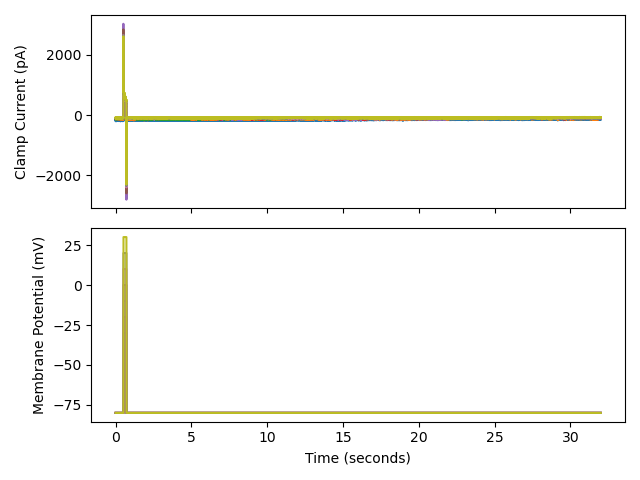

In [119]:
plt.close('all')
f = iv_files[1]
plot_swps(f)

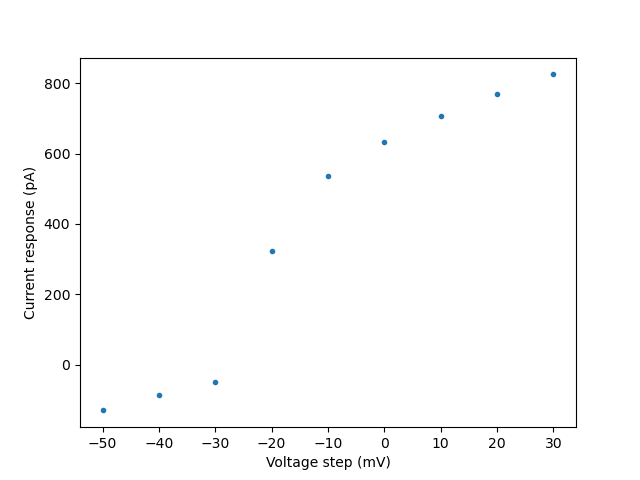

In [120]:
swps, swp_time, sr = get_sweeps(f)
## The mean on your voltage step:
v_start = 0.512
v_end = 0.7
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the pic response in your current:
i_start = 0.512
i_end = 0.55
current_window = swp_window(swps,i_start,i_end,sr,channel=0)
current_response = np.array([swp[np.argmax(np.abs(swp))] for swp in current_window])
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()

### activation curve

#### Normalise

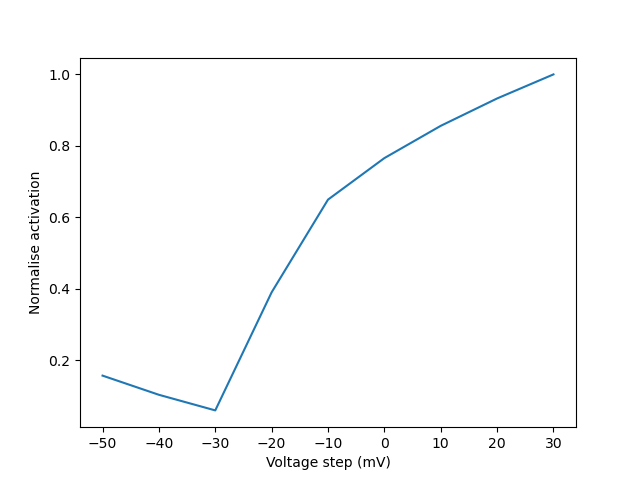

In [121]:
norm = np.abs(current_response/current_response.max())
fig, ax = plt.subplots()
ax.plot(voltage_step,norm)
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Normalise activation')
plt.show()

### Then when you have the reversal potential

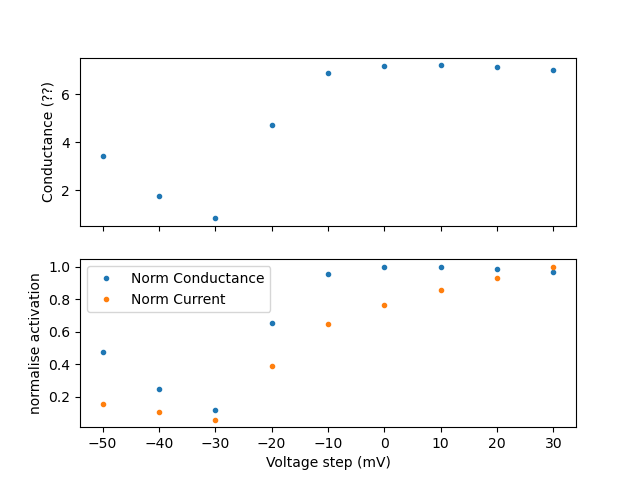

In [122]:
## reversal potential in mV
E_rev = -88 ## from the IV curve
conductance = np.abs(current_response/(voltage_step - E_rev))
## normalise
norm_g = conductance/conductance.max()
fig, ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,conductance,'.')
ax[1].plot(voltage_step,norm_g,'.',label='Norm Conductance')
ax[1].plot(voltage_step,norm,'.',label='Norm Current')
ax[1].set_ylabel('normalise activation')
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Conductance (??)')
ax[1].legend()
plt.show()

#### fit the activation curve

In [123]:
def fun_boltz(x, p):
    """Fit function for growth: single exponential + offset
    p[0] : V 50
    p[1] : slope
    """
    return 1.0 - (1.0/(1.0+np.exp((x-p[0])/p[1])))

def minimize_fun(p, x, y):
    return y-fun_boltz(x, p)

v50_init = 0.0
slope_init = 1.0
x = voltage_step
y = norm
p_guess = (v50_init,slope_init)
fit_boltz = leastsq(minimize_fun, p_guess, args=(x, y),full_output=True)
fit_params = fit_boltz[0]
print(fit_boltz[0])
fit_fun = fun_boltz(x,fit_params)
ax[1].plot(x,fit_fun,label=f"fit\n slope={fit_params[1]}\n V50={fit_params[0]} ")
ax[1].legend()

[-13.9222  10.9894]


### Tail Current 
#### Extract the current at the end of the voltage step:

In [152]:
baseline = np.mean(tail_current[:,-10:],axis=1)
tail_current - baseline[:, np.newaxis]

array([[ -452.9419,  -381.5308,  -321.106 , ...,    -1.8921,    -2.5024,
           -2.1973],
       [ -662.4146,  -576.0498,  -500.6714, ...,    -0.1831,     1.6479,
            0.1221],
       [ -793.5791,  -684.6313,  -592.1631, ...,     2.0142,    -0.1221,
           -3.479 ],
       ...,
       [-1352.1729, -1251.77  , -1159.9121, ...,     1.2817,     3.7231,
            0.9766],
       [-1424.7437, -1328.6133, -1240.7227, ...,    -0.7935,     1.3428,
            1.0376],
       [-1493.6218, -1408.4778, -1324.2493, ...,     1.1292,    -1.6174,
           -2.2278]])

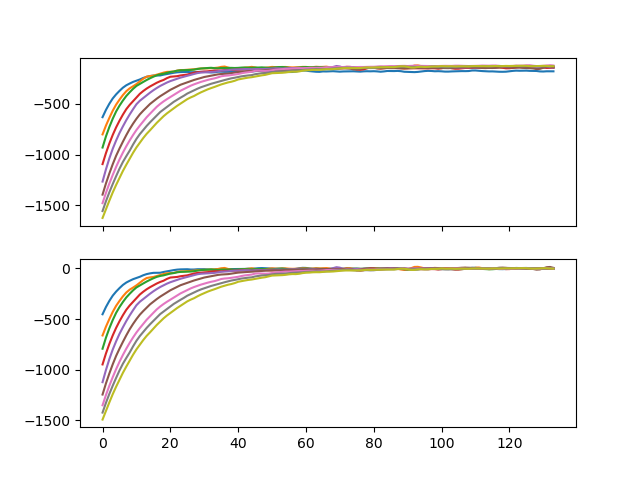

In [154]:
i_start = 0.7103 
i_end = 0.7130
tail_current = swp_window(swps,i_start,i_end,sr,channel=0)
## normalise with baseline (end of tail =0 )
baseline = np.mean(tail_current[:,-10:],axis=1)
norm_tail_current = tail_current - baseline[:, np.newaxis]
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(tail_current.T)
ax[1].plot(norm_tail_current.T)
plt.show()

In [183]:
def fit_exp(x_axis,ydata):
    def fun_exp(t, p):
        """Fit function for decay: single exponential + offset
        p[0] : amplitude
        p[1] : tau
        """
        ## THIS IS CRUCIAL !
        ## for a good fit you need to have the 
        ## params in the range of 0-1
        amp = p[0] * 1e3 ## nA
        tau = p[1] * 1e-3 # ms
        # offset = p[2] * 1e3 ## pA
        return 1 - (amp*np.exp(-t/tau))
    
    def minimize_fun(p, x, y):
        return y-fun_exp(x, p)
    
    x = x_axis
    y = ydata
    p_guess = [1,1]
    fit_exp = leastsq(minimize_fun, p_guess, args=(x, y))
    fit_params = fit_exp[0]
    fit_trace = fun_exp(x,fit_params)
    print(f'Amplitude = {round(fit_params[0]*1e3,1)} pA // Tau = {fit_params[1]*1e-3} ms')
    return fit_params,fit_trace

In [184]:
time = np.arange(len(tail_current[0])) / sr
time

array([0.    , 0.    , 0.    , ..., 0.0026, 0.0026, 0.0027])

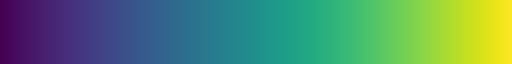

In [185]:
mp.colormaps['viridis']

Sweep 0
Amplitude = 443.2 pA // Tau = 0.12753109333428642 ms
Sweep 1
Amplitude = 657.6 pA // Tau = 0.14358684554823575 ms
Sweep 2
Amplitude = 783.4 pA // Tau = 0.14334367644509544 ms
Sweep 3
Amplitude = 934.8 pA // Tau = 0.17594039581132506 ms
Sweep 4
Amplitude = 1109.1 pA // Tau = 0.18833884407579662 ms
Sweep 5
Amplitude = 1233.4 pA // Tau = 0.22845100698128085 ms
Sweep 6
Amplitude = 1335.8 pA // Tau = 0.27376986964039585 ms
Sweep 7
Amplitude = 1407.1 pA // Tau = 0.30473178467552037 ms
Sweep 8
Amplitude = 1485.7 pA // Tau = 0.3313292109600831 ms


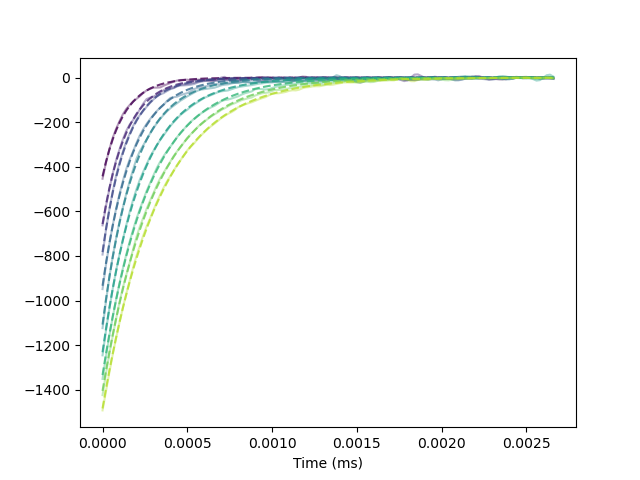

In [189]:
plt.close('all')
fig,ax = plt.subplots()
cmap = mp.colormaps['viridis']
fitted_params = []
for i,curr in enumerate(norm_tail_current[:]):
    print(f'Sweep {i}')
    p_fit,t_fit = fit_exp(time*1e3,curr)
    fitted_params.append(p_fit)
    color = cmap(i/len(tail_current))[:-1]
    ax.plot(time,curr,color=color,alpha=0.4)
    ax.plot(time,t_fit,'--',color=color,alpha=0.8)
    ax.set_xlabel('Time (ms)')
fitted_params = np.array(fitted_params) * np.array([1e3,1e-3])
plt.show()

Text(0, 0.5, 'Tau (ms)')

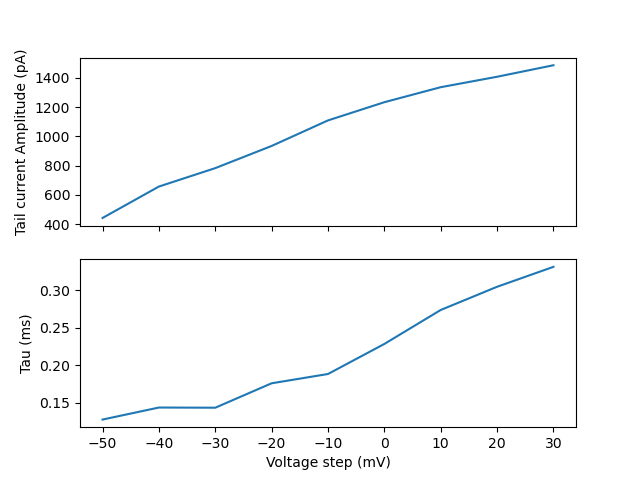

In [193]:
fig,ax = plt.subplots(2,sharex=True)
ax[0].plot(voltage_step,fitted_params[:,0])
ax[1].plot(voltage_step,fitted_params[:,1])
ax[1].set_xlabel('Voltage step (mV)')
ax[0].set_ylabel('Tail current Amplitude (pA)')
ax[1].set_ylabel('Tau (ms)')

### Deactivation you can do it I beleive in you :) 

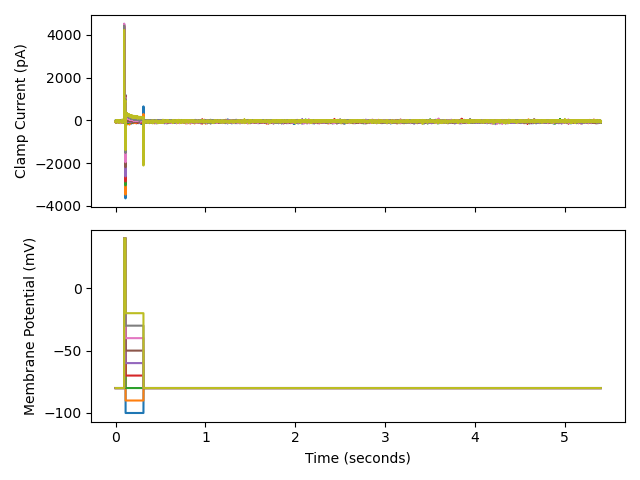

In [10]:
f = files[3]
plot_swps(f)

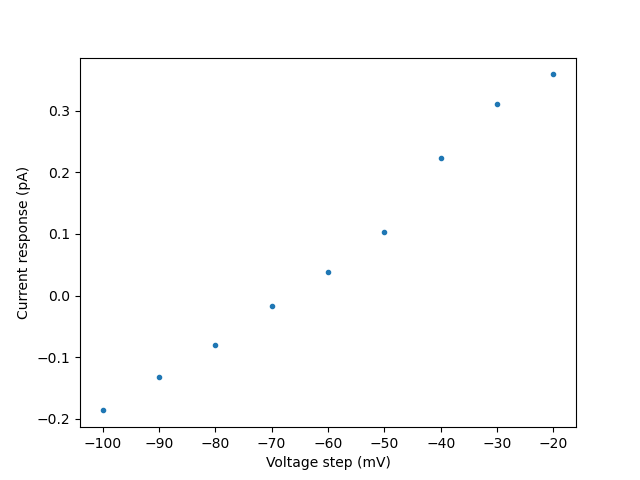

In [61]:
swps, swp_time, sr = get_sweeps(f)
## The mean on your voltage step:
v_start = 0.125
v_end = 0.3
voltage_step = np.mean(swp_window(swps,v_start,v_end,sr,channel=1),axis=1)
## the baseline current:
i_start = 0.05
i_end = 0.08
current_baseline = np.max(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## the reference pic response in your current:
i_start = 0.105
i_end = 0.108
ref_current = np.max(swp_window(swps,i_start,i_end,sr,channel=0),axis=1) - current_baseline  
## the pic response in your current:
i_start = 0.110
i_end = 0.115
current_response = np.max(swp_window(swps,i_start,i_end,sr,channel=0),axis=1) - current_baseline
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response/ref_current,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()

### You will need to fit this with a function : The same as the Tail current 

### Pharmacology

In [1]:
files = glob(folders[0]+"/*")
files

NameError: name 'glob' is not defined

In [ ]:
swps, swp_time, sr = get_sweeps(f)
## the pic response in your current:
i_start = 0.11341
i_end = 0.1155
current_response = np.min(swp_window(swps,i_start,i_end,sr,channel=0),axis=1)
## Create a figure plot with this line:
fig,ax = plt.subplots()
## the ax.plot(x,y,'line, dot,...') will plot your data to the figure
ax.plot(voltage_step,current_response,'.')
ax.set_xlabel('Voltage step (mV)')
ax.set_ylabel('Current response (pA)')
plt.show()